In [ ]:
# Transit 

In [1]:
import batman
import numpy as np
import matplotlib.pyplot as plt
from lightkurve import search_lightcurvefile
import ellc
from copy import copy, deepcopy
from scipy.signal import find_peaks

In [2]:
lc = search_lightcurvefile('WASP-18b',mission="TESS",sector=2).download()


In [3]:
lc1 = lc.PDCSAP_FLUX.normalize().remove_nans().flatten(145)

In [4]:
t, y, e = lc1.time, lc1.flux, lc1.flux_err
t = np.array([tt for tt in t])  

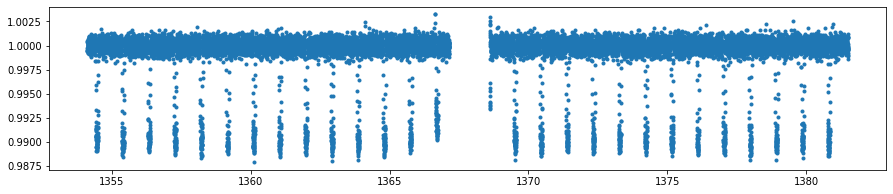

In [5]:
plt.figure(figsize=(15,3))
plt.plot(t,y,".")

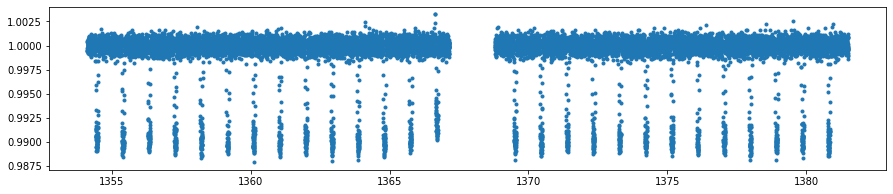

In [6]:
#remove incomplete transit around t = 1368.6

cutout = abs(t-1368.6)>0.2
t,y,e = t[cutout], y[cutout], e[cutout]

plt.figure(figsize=(15,3))
plt.plot(t,y,".");
#plt.plot(t[peaks],f[peaks],"x")

#### modeling the light curve

In [15]:
Rp = 0.09716 
aR = 3.562
ip = 85.88
P  = 0.9414526
t_ref = 2458375.169883 - 2457000    #reference transit time

In [8]:
###First using the standard batman model

In [9]:
def bat_model(time, pars):
    bat_params = batman.TransitParams()
    
    bat_params.per = P                    #orbital period
    bat_params.rp = pars[0]                     #planet radius (in units of stellar radii)
    bat_params.a = pars[1]                      #semi-major axis (in units of stellar radii)
    bat_params.inc = pars[2]                    #orbital inclination (in degrees)
    bat_params.ecc = 0                    #eccentricity
    bat_params.w = 90.                      #longitude of periastron (in degrees)
    bat_params.u = [0.5, 0.4]               #limb darkening coefficients
    bat_params.limb_dark = "quadratic"      #limb darkening model
    bat_params.t0 = pars[3]                     #time of inferior conjunction

    m = batman.TransitModel(bat_params, time)   #initializes model
    flux_batman = m.light_curve(bat_params)  #calculates light curve
    return flux_batman
 

In [10]:
pars= [Rp, aR, ip, tref]
f = bat_model( t, pars)    #standard light curve

Text(0.5, 0, 'Time (days)')

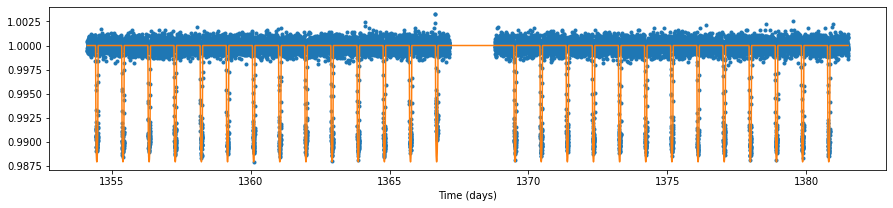

In [14]:
plt.figure(figsize=(15,3))
plt.plot(t,y,".")
plt.plot(t, f);
plt.xlabel("Time (days)")

### TTV modifications

To model TTVs in the data, it is possible to break up the data into individual transits so that each transit can have a unique mid-transit time `T0`

To do this i have added a function `split_transits` into the batman package.

- It uses a given reference transit time `t_ref` (can be gotten from literature) to identify times of transits and splits accordingly.

- If for some reason this is not satisfactory, it can also use Scipy's `find_peaks` algorithm to identify locations of significant dips in the light curve, which it then uses for splitting the data.

###### using `t_ref ` for splitting

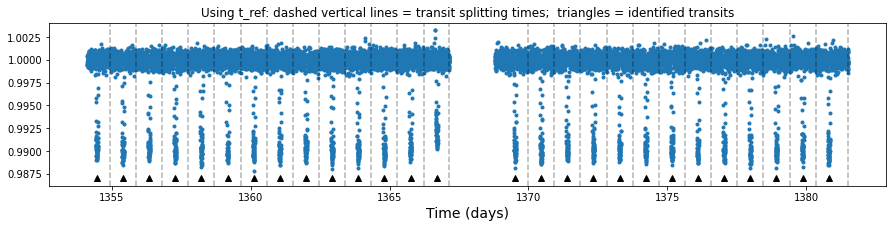

In [25]:
tr_times, tr_edges, indz, t0s = batman.split_transits(t, P, t_ref, y, show_plot=True)

We see that the transits are well identified (black arrows beneath) and the splitting edges accurately separates the individual transits

The ouputs gives:
- tr_times: list containing array of times of each transit
- tr_edges: list of split edges (shown as dashed vertical lines)
- indz: list containing array of indices of of the times in tr_times
- t0s: list of identified mid-transit times

In this data, there are 27 transits which are well identified

In [26]:
len(tr_times), len(tr_edges), len(indz), len(t0s)

(27, 27, 27, 27)

The returned indices (indz) from the `split_transits` function can also be used to plot each transit separately

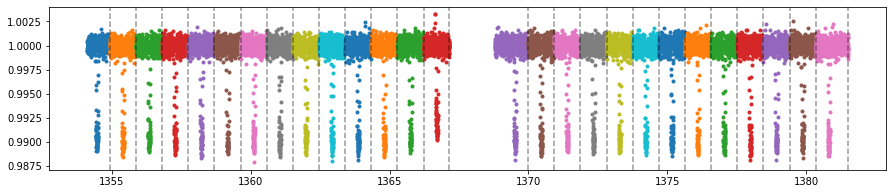

In [27]:
plt.figure(figsize=(15,3))

for i in range(len(indz)):
    plt.plot(t[indz[i]], y[indz[i]], ".")
    plt.axvline(tr_edges[i], ls="dashed", c="k", alpha=0.4, zorder=4)

##### using `find_peaks` for splitting

It uses the find_peaks algorithm to find peaks deeper than a certain `flux_value`. 
The `distance` between the peaks can also be specified to ensure that they are roughly 1 transit period away. The default is to estimate the number of samples within a Period by calculating the mean cadence - `P/np.mean(np.diff(t))`

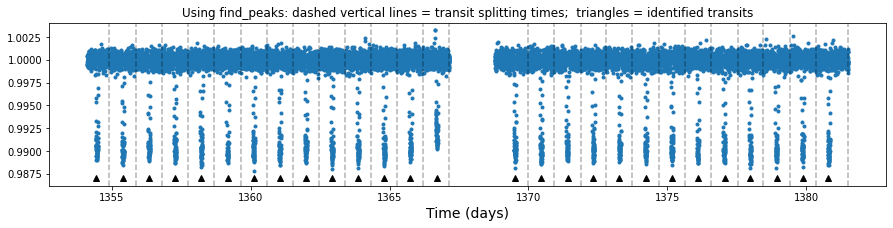

In [28]:
tr_times2,tr_edges2,indz2,t0s2 = batman.split_transits(t, P, flux= y, find_peaks=True,
                                                find_peaks_kw={"flux_value": 0.9925, "distance":None}, 
                                                   show_plot=True)

In [30]:
len(tr_times2), len(tr_edges2), len(indz2), len(t0s2)

(27, 27, 27, 27)

It performs equally good, identifying same transits as the previous method.

For visual confirmation of the split, We can overplot the standard transit model

Text(0.5, 1.0, 'dashed vertical lines show the transit splitting times')

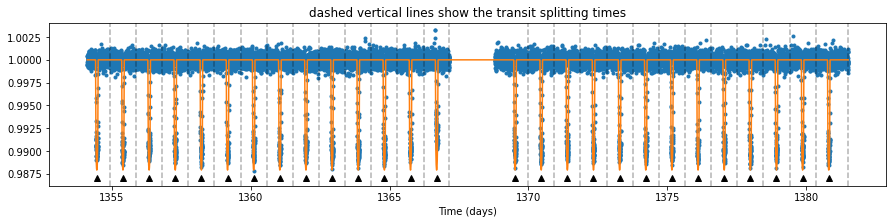

In [31]:
plt.figure(figsize=(15,3))
plt.plot(t,y,".")
plt.plot(t, f);
for edg in tr_edges: plt.axvline(edg, ls="dashed", c="k", alpha=0.3)
plt.plot(t0s, 0.987*np.ones_like(t0s),"k^");
plt.xlabel("Time (days)")
plt.title("dashed vertical lines show the transit splitting times")

### Now to create a model that can be used for fitting the transit parameters and the individual T0s

In [32]:
#TTV model
def bat_ttv_model(pars,time):
    params = batman.TransitParams()
        
    params.per = P                          #orbital period
    params.t_ref = tref                     #reference time used to break up the transits as illustrated before
    params.rp = pars[0]                     #planet radius (in units of stellar radii)
    params.a = pars[1]                      #semi-major axis (in units of stellar radii)
    params.inc = pars[2]                    #orbital inclination (in degrees)
    params.ecc = 0                          #eccentricity
    params.w = 90.                          #longitude of periastron (in degrees)
    params.u = [0.5, 0.4]                   #limb darkening coefficients
    params.limb_dark = "quadratic"          #limb darkening model
    params.t0 = pars[3:]                    #time of inferior conjunction for each transit. This c
    
    
    #notice the different function used to calculate the transit model
    ttv_batflux = batman.TTV_TransitModel(params, time)
           
        
    return ttv_batflux


Notice the difference in the function that generates the light curve `batman.TTV_TransitModel`.

This function first makes a function call to `split_transits` in order to split the transit in same way you have confirmed earlier to be accurate. It uses the new  `params.t_ref` value to make the split (or one can similarly use the find_peaks, in which case you specify the required inputs to use to the `batman.TTV_TransitModel`). It is important to have visualized the split before now to ensure that the data is splitted accurately so that the same inputs are then passed here.

Then it uses the t0 values in `params.t0` (which is now an array/list) to generate light curve for each transit segment. 

The result `ttv_batflux` is a concatenation of the individual transit models.

##### Model a ttv transit

In [35]:
pars= [Rp, aR, ip]     #same as before
#extend input parameters by t0 for each transit. The model expects the last parameter values to be t0 values
pars.extend(t0s)       #starting values for T0 could be gotten from split_transits function    

#Now modify some of the t0s so that they are slightly different from values of linear ephemeris

pars[-1]=pars[-1]+0.4*P     #last transit shifted forward by 0.4*P
pars[-5]=pars[-5]-0.3*P

In [36]:
#call the model with the input params
flux_ttv = bat_ttv_model(pars, t)

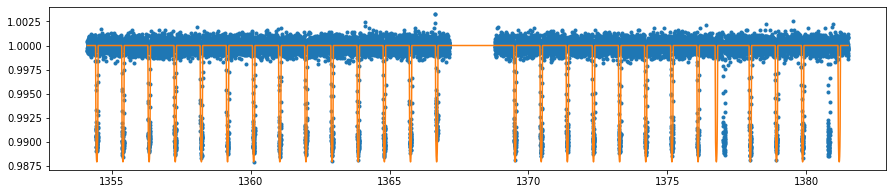

In [38]:
plt.figure(figsize=(15,3))
plt.plot(t,y,".")
plt.plot(t, flux_ttv)

Notice the shift in the 2 transits modified. The model can thus model all the transits with the same paramters but with different t0s

In [10]:
def separate_transits(t_ref, P, t):
    tref = t_ref
    if t_ref < t.min() or t.max() < t_ref:        #if reference time t0 is not within this timeseries
        #find transit time that falls around middle of the data
        ntrans = int((np.median(t) - tref)/P)   
        tref = t0 + ntrans*P
            
    nt = round( (tref-t.min())/P )                            #how many transits behind tref is the first transit
    tr_first = tref - nt*P                                    #time of first transit in data
    tr_last = tr_first + int((t.max() - tr_first)/P)*P        #time of last transit in data
    
    n_tot_tr = round((tr_last - tr_first)/P)                    #total nmumber of transits in data_range
    t0s = [tr_first + P*n for n in range(n_tot_tr+1) ]
    t_breaks = [(tr_first + 0.5)+P*n for n in range(n_tot_tr)]  #times to break transits, 0.5*P after each transit
    
    
    #collect times within each transit and the indices
    tr_times = [ t[(t>=t_breaks[i]) & (t<t_breaks[i+1])] for i in range(0,len(t_breaks)-1) ]
    indz = [ np.argwhere((t>=t_breaks[i]) & (t<t_breaks[i+1])).reshape(-1) for i in range(0,len(t_breaks)-1) ]

    tr_times.insert(0,t[t<t_breaks[0]])                                   #first transit
    indz.insert(0,np.argwhere(t<t_breaks[0]).reshape(-1)) 
    
    tr_times.append(t[t>=t_breaks[-1]])                                    #last transit
    indz.append(np.argwhere(t>=t_breaks[-1]).reshape(-1))
    
    tr_t = list(filter(lambda x: x.size>0, tr_times))                      #any empty subarray is removed
    indz = list(filter(lambda x: x.size>0, indz))
    t0s = list(filter(lambda t0: (t[(t<t0+0.1*P)&(t>t0-0.1*P)]).size>0, t0s))
    tr_edges = [tr[-1] for tr in tr_t]
    
    return tr_t, tr_edges, indz, t0s


def generate_times_from_t0(t0, P, t):
    
    tr_times = [t[( t>=(t0[i]-0.5*P) ) & ( t<(t0[i]+0.5*P) )] for i in range(1,len(t0)-1)]
    tr_times.insert(0, t[( t<(t0[0]+0.5*P) )])
    tr_times.append( t[( t>=(t0[-1]-0.5*P) )])
    
    #tr_t = list(filter(lambda x: x.size>0, tr_times))                      #any empty subarray is removed
    return tr_times

def generate_times_from_t02(t0, P, t):

    tr_times2= []
    for i in range(len(t0)):
        if i==0: 
            tr_times2.append(t[( t<(t0[i]+0.5*P) )])
            #print("doing 0")
        elif i == len(t0)-1: 
            tr_times2.append( t[( t>=(t0[i]-0.5*P) )])
            #print("doing last")
        else: 
            tr_times2.append( t[( t>(tr_times2[i-1][-1]) ) & ( t<(t0[i]+0.5*P) )] )
            #print(f"doing middle {i}")
    
    return tr_times2

In [29]:
trt =generate_times_from_t02(t0s, P, t)
len(np.concatenate(trt))

18176